In [2]:
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from models.epistemic_predictor import EpistemicPredictor
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

import warnings
warnings.filterwarnings('ignore')

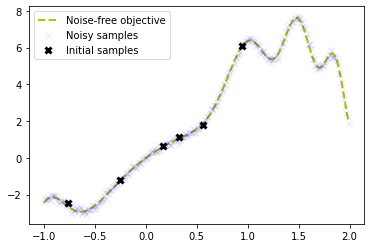

In [3]:
noise = 0.1

def f(X, noise=noise):
    return (-torch.sin(5*X**2) - X**4 + 0.3 *X** 3 + 2 * X **2 + 4.1*X + 
            noise * torch.randn_like(X))

def repeat(f, bounds):
    new_bounds = (bounds[0], 2 * bounds[1] - bounds[0])
    def g(X, noise=noise):
        return (X < bounds[1]) * f(X, noise) + (X >= bounds[1]) * (f(X - bounds[1] + bounds[0], noise) + 
                                                                  f(torch.FloatTensor([bounds[1]]), 0) -
                                                                   f(torch.FloatTensor([bounds[0]]), 0))
    return g, new_bounds
    

bounds = (-1, 2)
# f, bounds = repeat(f, bounds)
# f, bounds = repeat(f, bounds)

X_init = (bounds[1] - bounds[0]) * torch.rand(6, 1) + bounds[0]
Y_init = f(X_init)

X = torch.arange(bounds[0], bounds[1], 0.01).reshape(-1, 1)
Y = f(X, 0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [15]:
def optimize(model_name, plot=False, n_steps=5, **kwargs):
    train_X = X_init
    train_Y = Y_init
    ood_X =  (bounds[1] - bounds[0]) * torch.rand(7, 1) + bounds[0]
    additional_data = {'ood_X': ood_X,
                      'ood_Y': f(ood_X),
                      'train_Y_2': f(train_X)}
    state_dict = None
    max_value_per_step = [train_Y.max().item()]
    for _ in range(n_steps):
        if model_name == EpistemicPredictor:
            model = model_name(train_X, train_Y, additional_data, **kwargs)
            if state_dict is not None:
                model.load_state_dict(state_dict)
            for _ in range(5):
                model.fit()
        elif model_name == SingleTaskGP:
            model = model_name(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            if state_dict is not None:
                model.load_state_dict(state_dict)
            fit_gpytorch_model(mll)
        else:
            raise Exception('Not sure this would work !')


        EI = ExpectedImprovement(model, train_Y.max().item())
        eis = EI(X.unsqueeze(1)).detach()
        max_ei, argmax_ei = torch.max(eis, 0)
        xmax = X[argmax_ei].item()
        max_ei = max_ei.item()
        
        bounds_t = torch.FloatTensor([[bounds[0]], [bounds[1]]])
        candidate, acq_value = optimize_acqf(
            EI, bounds=bounds_t, q=1, num_restarts=5, raw_samples=50,
        )

        train_X = torch.cat([train_X, candidate])
        train_Y = torch.cat([train_Y, f(candidate)])
        additional_data['train_Y_2'] = torch.cat([additional_data['train_Y_2'], f(candidate)])
        state_dict = model.state_dict()
        
        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
            # Plot optimization objective with noise level 
            ax1.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
            ax1.plot(X, f(X), 'rx', lw=1, alpha=0.2, label='Noisy samples')
            ax1.plot(train_X, train_Y, 'kx', mew=3, label='Initial samples')

            ax1.plot(X, model(X).mean.detach().squeeze(), label='mean pred')
            ax1.fill_between(X.numpy().ravel(), model(X).mean.detach().numpy().ravel() - model(X).stddev.detach().numpy().ravel(),
                            model(X).mean.detach().numpy().ravel() + model(X).stddev.detach().numpy().ravel(), alpha=.4)
            
            if isinstance(model, EpistemicPredictor):
                ax1.plot(X, model.kde.score_samples(X), 'r-', label='density')


            ax2.plot(X, eis, 'r-', label='EI')
            ax2.plot(X, [max_ei] * len(X), 'b--')
            ax2.plot([xmax] * 100, torch.linspace(0, max_ei, 100), 'b--')
            ax1.legend()
            ax2.legend()
            
        max_value_per_step.append(train_Y.max().item())
        
    return max_value_per_step

        

In [23]:
import numpy as np
n_runs = 5
n_steps = 25
gp_runs = np.zeros((n_runs, n_steps + 1))
ep_runs = np.zeros((n_runs, n_steps + 1))

for i in range(n_runs):
    print(f"Run {i+1}/{n_runs}")
    gp_runs[i] = optimize(SingleTaskGP, plot=False, n_steps=n_steps, n_hidden=64)
    ep_runs[i] = optimize(EpistemicPredictor, plot=False, n_steps=n_steps, n_hidden=64)

Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


In [24]:
print(gp_runs.mean(0))
print(ep_runs.mean(0))

[6.08317614 6.08317614 6.37509727 6.37509727 6.42547512 6.43193874
 6.89122744 7.4666728  7.63400545 7.63992939 7.63992939 7.64046955
 7.67692833 7.68032141 7.7202549  7.75056953 7.75418043 7.76604795
 7.76604795 7.76604795 7.76604795 7.76604795 7.76604795 7.76604795
 7.76604795 7.76604795]
[6.08317614 6.08317614 6.20137348 6.40151091 6.45490332 6.47545948
 6.52427921 6.52427921 6.52825813 6.52825813 6.52825813 6.55284977
 6.55284977 6.63389091 7.09390459 7.25563059 7.26754484 7.26797142
 7.27616806 7.31633892 7.31633892 7.31633892 7.31633892 7.31633892
 7.31633892 7.31633892]


In [25]:
print(gp_runs.std(0))
print(ep_runs.std(0))

[0.         0.         0.03947064 0.03947064 0.05092713 0.04349547
 0.22958202 0.30465426 0.10252015 0.09809891 0.09809891 0.09836473
 0.13636815 0.13193628 0.10165325 0.07292853 0.0685315  0.05819843
 0.05819843 0.05819843 0.05819843 0.05819843 0.05819843 0.05819843
 0.05819843 0.05819843]
[0.         0.         0.12596777 0.14226977 0.10836051 0.09176137
 0.07848755 0.07848755 0.07429199 0.07429199 0.07429199 0.06628286
 0.06628286 0.15524784 0.42024348 0.5447143  0.55026768 0.5504846
 0.55489105 0.58270669 0.58270669 0.58270669 0.58270669 0.58270669
 0.58270669 0.58270669]


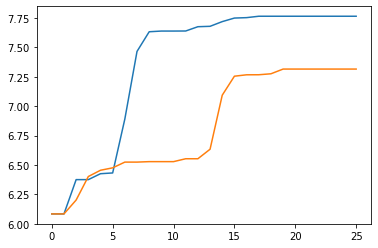

In [27]:
plt.plot(gp_runs.mean(0), label='gp')
plt.plot(ep_runs.mean(0), label='ep')